In [ ]:
#pretrained model download
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ff1zh592
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-ff1zh592
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=ceb60dff77734466d93a82023a36fe90a4c25e86b18eff6ca517bc5e3acfeedf
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfcp9khr/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
#기본 라이브러리 임포트
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
# tfds = dataset 다운로드 받는 라이브러리
import tensorflow_datasets as tfds
# pix2pix에서 미리 짜여진 모델을 가져올 예정(UNET 기반)
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
#dataset download
dataset, metadata = tfds.load('Cycle_gan/vangogh2photo',
                              with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteO46AGU/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteO46AGU/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteO46AGU/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteO46AGU/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


In [ ]:
train_A, train_B = dataset['trainA'] , dataset['trainB']
test_A, test_B = dataset['testA'] ,dataset['testB']

In [ ]:
train_B

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# 데이터 증강
IMG_WIDTH = 256
IMG_HEIGHT = 256
def random_crop(image):
    cropped_image = tf.image.random_crop(image,
                                         size=[IMG_WIDTH, IMG_HEIGHT,3])
    return cropped_image

In [ ]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    image = tf.image.resize(image,[286,286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # 이미지 사이즈를 286, 286 사이즈로 조정, 이미지를 늘리거나 줄일때, 모르는 픽셀값
    # 정보를 주변 픽셀값으로(nearest_neighbor) 채워라
    image = random_crop(image)
    image = tf.image.flip_left_right(image)
    return image

In [ ]:
def preprocess_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_test(image,label):
    # 테스트 데이터는 증강이 필요 없으니
    return normalize(image)

In [ ]:
# Pytorch  modeling
# dataset -> dataloader -> model -> loop
# tf modeling
# dataset load -> model -> model fit
# 데이터 전처리 , 학습중 병목 현상을 제거하기 위한 prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_A = train_A.cache().map(
    preprocess_train, num_parallel_calls= AUTOTUNE).shuffle(1000).batch(16)
train_B = train_B.cache().map(
    preprocess_train, num_parallel_calls= AUTOTUNE).shuffle(1000).batch(16)
test_A = test_A.cache().map(
    preprocess_test, num_parallel_calls= AUTOTUNE).shuffle(1000).batch(16)
test_B = test_B.cache().map(
    preprocess_test, num_parallel_calls= AUTOTUNE).shuffle(1000).batch(16)

In [ ]:
'''
for sample in train_A:
    print(sample)
    break
'''
sample_a = next(iter(train_A))
#sample_a

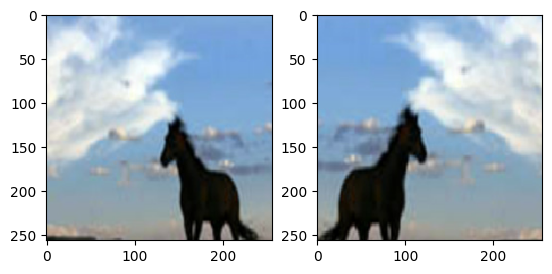

In [ ]:
plt.subplot(121)
plt.imshow(sample_a[1]*0.5 +0.5)
plt.subplot(122)
plt.imshow(random_jitter(sample_a[1]*0.5 +0.5))

In [ ]:
#model
generator_g = pix2pix.unet_generator(3, norm_type= 'instancenorm')
generator_f = pix2pix.unet_generator(3, norm_type= 'instancenorm')
discriminator_g = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_f = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
discriminator_f.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential_33 (Sequential)  (None, None, None, 64)    3072      
                                                                 
 sequential_34 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_35 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d_2 (ZeroPadd  (None, None, None, 256)   0         
 ing2D)                                                          
                                                                 
 conv2d_24 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

In [ ]:
# to_zebra = generator_g(sample_a) 모델 정상 작동 확인

loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#from logits : 아웃풋 층이, sigmoid 혹은 softmax 활성화 함수를 사용 하는가?
def discriminator_loss(real, fake):
    # 판별자 손실 값은 진짜 데이터(1)를 보여주면, 1이라고 대답
    # 가짜 데이터 보여주면(0) , 0 이라고 대답  두가지 카테고리 분류, binary_cross_entropy
    real_loss = loss_function(tf.ones_like(real),real)
    fake_loss = loss_function(tf.zeros_like(fake) , fake)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss * 0.5

In [ ]:
def generator_loss(fake):
    # 생성자의 loss는 판별자에게 달려 있다!
    # 가짜 이미지를 판별자에게 보여줘서 다 참(1)이라고 말하면 loss는 0
    return loss_function(tf.ones_like(fake) , fake)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    tmp_loss =  tf.reduce_mean(tf.abs(real_image - cycled_image))
    # x -> fake y -> fake x
    # fake x 와 x가 같은가? 를 계산 즉, 픽셀값이 동일 한가?
    # 10배를 키우는 이유는 픽셀값의 범위가 매우 작은 상태(normed)
    # cycle loss의 영향력을 키우기 위해 10배 강제 증폭
    return 10 * tmp_loss

In [ ]:
# 갈색말을 얼룩말로 바꿔주는 생성자에게
# 얼룩말 사진을 넣으면 바꿀게 없으니 그대로 나와야함(identity loss)
def identity_loss(real_image , fake_image):
    tmp_loss = tf.reduce_mean(tf.abs(real_image - fake_image))
    return 5 * tmp_loss

In [ ]:
# optimizer
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

In [ ]:
#checkpoint 설정
checkpoint_path = '/content/drive/MyDrive/cycle_gan_checkpoint'
ckpt = tf.train.Checkpoint(generator_g = generator_g,
                           generator_f = generator_f,
                           discriminator_g = discriminator_g,
                           discriminator_f = discriminator_f,
                           generator_g_optimizer = generator_g_optimizer,
                           generator_f_optimizer = generator_f_optimizer,
                           discriminator_g_optimizer = discriminator_g_optimizer,
                           discriminator_f_optimizer = discriminator_f_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('restore ok')



In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)

    display_title_list = ['input image', 'predict image']
    display_list = [test_input[0], prediction[0]]
    plt.figure(figsize=(12,12))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(display_title_list[i])
        plt.imshow(display_list[i]*0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        #real x -> fake y
        fake_y = generator_g(real_x, training = True)
        # fake y -> cycle x
        cycled_x = generator_f(fake_y , training = True)
        # real y -> fake x
        fake_x = generator_f(real_y, training=True)
        # fake x -> cycle y
        cycled_y =generator_g(fake_x, training=True)
        # real y -> fake y (identity)
        same_y = generator_g(real_y , training=True)
        # real x -> fake x (identity)
        same_x = generator_f(real_x , training=True)

        #discriminator
        disc_real_x = discriminator_f(real_x , training = True)
        disc_real_y = discriminator_g(real_y , training=True)
        disc_fake_x = discriminator_f(fake_x, training=True)
        disc_fake_y = discriminator_g(fake_y, training=True)

        # calculate loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x,cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Total loss를 기반으로 generator g에 대한 변수들의 개별적 gradient값을 계산
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_f.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_g.trainable_variables)

    #각 변수(trainable variables)들에 대한 gradient를 기반으로 변수 업데이트
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                          generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                          generator_f.trainable_variables))
    discriminator_f_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                              discriminator_f.trainable_variables))
    discriminator_g_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                              discriminator_g.trainable_variables))


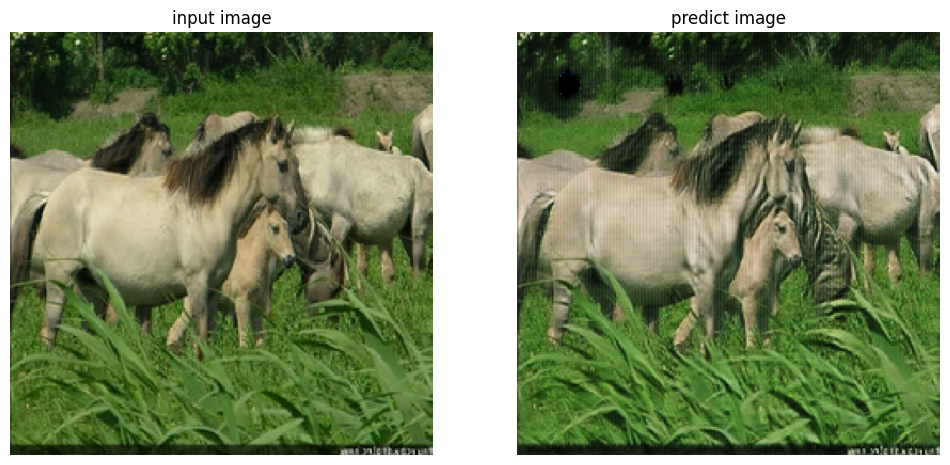

In [ ]:
for epoch in range(200):
    n = 0

    print('epoch :',epoch)
    for image_x, image_y in tf.data.Dataset.zip((train_A,train_B)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('-',end='')
        n+=1
    clear_output(wait=True)
    generate_images(generator_g, image_x)

    if (epoch + 1) % 5 == 0:
        ckpt_manager.save()



